In [1]:
%run data_cleaning.py

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [3]:
df_cleaned.head()
status_counts = df_cleaned['Status'].value_counts()

# Display the counts
print("Counts of Status:")
print(status_counts)

Counts of Status:
0    3171
1     337
Name: Status, dtype: int64


In [4]:
df_cleaned.head()

,Age,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size (mm),Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status
0,68,0,0,0,2,1,4,1,1,24,1,60,0
1,50,1,1,2,1,1,35,1,1,14,5,62,0
2,58,2,2,4,1,1,63,1,1,14,7,75,0
3,58,0,0,0,2,1,18,1,1,2,1,84,0
4,47,1,0,1,2,1,41,1,1,3,1,50,0


In [5]:
#Only taking people who are alive from column "Status" as it makes no sense to predict if the tumor will grow on dead people (0 is alive)
df_alive = df_cleaned[df_cleaned['Status'] == 0]


In [6]:
df_alive.head()

,Age,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size (mm),Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status
0,68,0,0,0,2,1,4,1,1,24,1,60,0
1,50,1,1,2,1,1,35,1,1,14,5,62,0
2,58,2,2,4,1,1,63,1,1,14,7,75,0
3,58,0,0,0,2,1,18,1,1,2,1,84,0
4,47,1,0,1,2,1,41,1,1,3,1,50,0


In [7]:
df_alive.drop(["T Stage", "6th Stage"], axis=1, inplace=True)

/var/folders/_c/s1yyycpn5s50m8qmlf_cz70h0000gn/T/ipykernel_1162/327196009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alive.drop(["T Stage", "6th Stage"], axis=1, inplace=True)


In [8]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

#Using a threshold of 40 mm (4 cm) because usually after the tumor reaches that size it becomes very serious
threshold = 40
X = df_alive.drop("Tumor Size (mm)", axis=1)
y = (df_alive["Tumor Size (mm)"] > threshold).astype(int)  # binary target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logreg = LogisticRegression(max_iter=10000, random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]  # Probability of tumor growth beyond the threshold
logistic_loss = log_loss(y_test, y_pred_proba)

print("Logistic loss:", logistic_loss)

Accuracy: 0.8740157480314961
Logistic loss: 0.37231217533488514


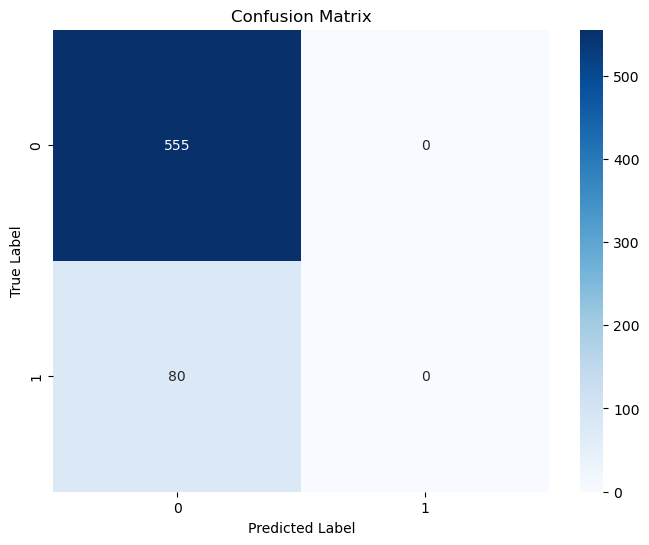

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
#2155 = predicted value is positive and it's actually positive
#225 = predicted value is negative and it's actually negative
#150 = predicted value is negative but it's positive
#26 = predicted value is positive but it's negative

In [11]:
# Cross validationb, optimization
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, log_loss

threshold = 40
X = df_alive.drop("Tumor Size (mm)", axis=1)
y = (df_alive["Tumor Size (mm)"] > threshold).astype(int)  
scaler = StandardScaler()
logreg = LogisticRegression(max_iter=10000, random_state=42)

# Create a KFold object with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Creating lists because there will be 5 of them
cv_accuracy = []
cv_log_loss = []

# Splitting it into 5 
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
 
    logreg.fit(X_train_scaled, y_train)
    
    # Making predictions 
    y_pred = logreg.predict(X_test_scaled)
    y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics and add them to the listss
    accuracy = accuracy_score(y_test, y_pred)
    log_loss_score = log_loss(y_test, y_pred_proba)
    
    cv_accuracy.append(accuracy)
    cv_log_loss.append(log_loss_score)

print("Cross validation accuracy scores:", cv_accuracy)
print("Cross validation logistic loss scores:", cv_log_loss)

print("Mean of cross validation: ", np.mean(cv_accuracy))
print("Mean of cross validation logictic loss:", np.mean(cv_log_loss))



Cross validation accuracy scores: [0.8740157480314961, 0.8359621451104101, 0.8359621451104101, 0.8580441640378549, 0.8375394321766562]
Cross validation logistic loss scores: [0.3723121753348851, 0.43093634239723577, 0.43334026995215114, 0.39270308643435414, 0.4302295753509779]
Mean of cross validation:  0.8483047268933654
Mean of cross validation logictic loss: 0.4119042898939208
